# Combined SNP and covariate absolute risk model

In this example, we demonstrate the use of iCARE to build models of absolute risk containing both classical risk factors and SNPs. Here, we assume that we have a reference dataset to represent the distribution of the classical risk factors in the underlying population. However, we do not have a reference dataset for the SNPs. So, we make use of iCARE's special SNP option to simulate the reference dataset to represent the distribution of SNPs in the underlying population.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import icare


# Set the plot background to white
sns.set(style="whitegrid", rc={"axes.facecolor": "white", "grid.color": "white"})

To specify a covariate model in iCARE, we need to provide: 1) a text file containing the formula (using [the Patsy formula language](https://patsy.readthedocs.io/en/latest/formulas.html)) to describe the covariate model (`model_covariate_formula_path`), 2) breast cancer log odds ratios associated with each risk factor in the covariate model (`model_log_relative_risk_path`), 3) a reference dataset describing the distribution of the classical risk factors in the underlying population (`model_reference_dataset_path`), 4) a set of profiles, specifying the classical risk factors, using which the absolute risk is to be estimated, and 5) the marginal age-specific incidence rates of breast cancer (`model_competing_incidence_rates_path`).

To specify a SNP-only model using the special option, we must input the file containing the marginal age-specific incidence rates of breast cancer (`model_competing_incidence_rates_path`), and the SNP information (`model_snp_info_path`), that has three columns named: (`snp_name`, `snp_odds_ratio`, and `snp_freq` corresponding to the SNP name, their odds ratios in association with breast cancer risk, and their minor allele frequencies, respectively). Marginal age-specific incidence rates of competing risks (`model_competing_incidence_rates_path`) are optional. We include them in this example.

The covariate model described in the files in the following cell is based on a logistic regression model adjusted for cohort and fine categories of age  in the Breast and Prostate Cancer Cohort Consortium ([Campa et al. 2011](https://pubmed.ncbi.nlm.nih.gov/21791674/), [Joshi et al. 2014](https://pubmed.ncbi.nlm.nih.gov/25255808/), and [Maas et al. 2016](https://pubmed.ncbi.nlm.nih.gov/27228256/)). The reference dataset was created by simulation from [the National Health Interview Survey (NHIS)](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NHIS/2010/srvydesc.pdf) and [the National Health and Nutrition Examination Survey (NHANES)](https://wwwn.cdc.gov/nchs/nhanes/default.aspx), which are representative of the US population. `breast_cancer_72_snps_info.csv` contains published information on the odds-ratios and allele frequencies of 72 SNPs identified, among a larger set of markers, to be associated with breast cancer risk by [a recent genome-wide association study](https://www.nature.com/articles/nature24284) (Michailidou et al., 2017). `age_specific_breast_cancer_incidence_rates.csv` contains age-specific incidence rates of breast cancer from [Surveillance, Epidemiology and End Results (SEER) Program](https://seer.cancer.gov/), and `age_specific_all_cause_mortality_rates.csv` has age-specific incidence rates of all-cause mortality from [the CDC WONDER database](https://wonder.cdc.gov/). We indicate `model_family_history_variable_name = "family_history"` to allow the software to properly attenuate the log odds ratio for family history to account for the addition of the 72 SNPs.

In [2]:
apply_age_start = 50
apply_age_interval_length = 30
model_covariate_formula_path = "../data/breast_cancer_covariate_model_formula.txt"
model_log_relative_risk_path = "../data/breast_cancer_model_log_odds_ratios.json"
model_reference_dataset_path = "../data/reference_covariate_data.csv"
apply_covariate_profile_path = "../data/query_covariate_profile.csv"
model_snp_info_path = "../data/breast_cancer_72_snps_info.csv"
apply_snp_profile_path = "../data/query_snp_profile.csv"
model_family_history_variable_name = "family_history"
model_disease_incidence_rates_path = "../data/age_specific_breast_cancer_incidence_rates.csv"
model_competing_incidence_rates_path = "../data/age_specific_all_cause_mortality_rates.csv"

In [3]:
results = icare.compute_absolute_risk(
    apply_age_start=apply_age_start,
    apply_age_interval_length=apply_age_interval_length,
    model_covariate_formula_path=model_covariate_formula_path,
    model_log_relative_risk_path=model_log_relative_risk_path,
    model_reference_dataset_path=model_reference_dataset_path,
    apply_covariate_profile_path=apply_covariate_profile_path,
    model_snp_info_path=model_snp_info_path,
    apply_snp_profile_path=apply_snp_profile_path,
    model_family_history_variable_name=model_family_history_variable_name,
    model_disease_incidence_rates_path=model_disease_incidence_rates_path,
    model_competing_incidence_rates_path=model_competing_incidence_rates_path,
    return_reference_risks=True
)

The method returns a dictionary containing the following keys:

In [4]:
results.keys()

dict_keys(['model', 'profile', 'reference_risks'])

The `model` key contains the absolute risk model parameters, i.e., the log odds-ratios for each classical risk factor and SNP in association with breast cancer risk:

In [5]:
model = pd.Series(results["model"])
model

C(age_at_menarche, levels=['<=11', '11-11.5', '11.5-12', '12-13', '13-14', '14-15', '>=15'])[T.11-11.5]    0.044431
C(age_at_menarche, levels=['<=11', '11-11.5', '11.5-12', '12-13', '13-14', '14-15', '>=15'])[T.11.5-12]   -0.035407
C(age_at_menarche, levels=['<=11', '11-11.5', '11.5-12', '12-13', '13-14', '14-15', '>=15'])[T.12-13]     -0.086565
C(age_at_menarche, levels=['<=11', '11-11.5', '11.5-12', '12-13', '13-14', '14-15', '>=15'])[T.13-14]     -0.109902
C(age_at_menarche, levels=['<=11', '11-11.5', '11.5-12', '12-13', '13-14', '14-15', '>=15'])[T.14-15]     -0.085482
                                                                                                             ...   
rs2284378                                                                                                  0.000000
rs2823093                                                                                                 -0.061875
rs17879961                                                              

The `profile` key contains the classical risk factors, genetic risk factors, and the estimated absolute risk for each queried profile:

In [6]:
profiles = pd.read_json(results["profile"], orient="records")
profiles

,id,age_interval_start,age_interval_end,risk_estimates,family_history,age_at_menarche,parity,age_at_first_child_birth,age_at_menopause,height,...,rs527616,rs1436904,rs6507583,rs4808801,rs3760982,rs2284378,rs2823093,rs17879961,rs132390,rs6001930
0,Q-01,50,80,0.102718,0,13-14,0,19-22,40-45,1.63-1.65,...,0,0,0,1,0,1,1,0,0,0
1,Q-02,50,80,0.089801,0,>=15,0,19-22,<=40,1.63-1.65,...,0,0,0,1,1,1,0,0,0,0
2,Q-03,50,80,0.168961,0,<=11,0,<=19,51-52,<=1.55,...,1,1,0,1,1,0,0,0,0,0


The `reference_risks` key contains the absolute risks of the reference population:

In [7]:
reference_risks = results["reference_risks"]

The summary statistics of the absolute risks of the reference population are:

In [8]:
pd.DataFrame(reference_risks[0]["population_risks"]).describe()

,0
count,14137.000000
mean,0.096226
std,0.032265
min,0.030400
25%,0.073220
50%,0.090170
75%,0.112916
max,0.301991


We can plot the absolute risks of the reference population and the queried profiles:

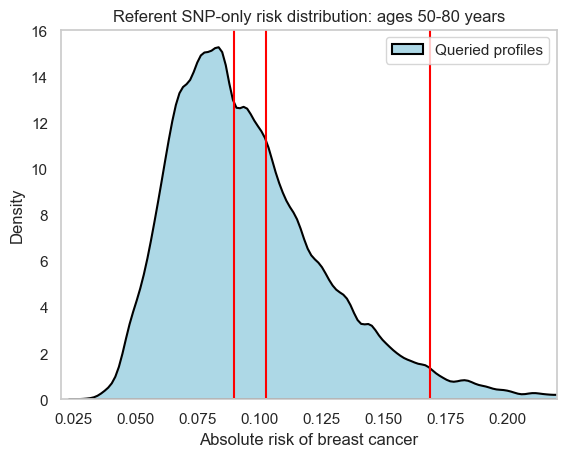

In [9]:
# Plot the density plot
sns.kdeplot(reference_risks[0]["population_risks"], bw_adjust=0.5, color="black", fill=True, alpha=0.3, linewidth=1.5, facecolor="lightblue")
plt.xlim(0.02, 0.22)
plt.xlabel("Absolute risk of breast cancer")
plt.title("Referent SNP-only risk distribution: ages 50-80 years")

# Add a vertical red line, one for each queried profile
for risk_value in profiles["risk_estimates"]:
    plt.axvline(risk_value, color="red")

plt.legend(["Queried profiles"], loc="upper right")

plt.show()